# M3 – Week 1

### Towards an image classification pipeline

This work was made by Edward Hogea, Alex Carrillo and Guillem Martínez


On these notebook, we adress the objective of generating an image classification pipeline employing a Bag Of Visual Words (BOVW) algorithm. 

### Imports

In [258]:
import os
import cv2
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from typing import List, Dict, Tuple, Any
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model._base import BaseEstimator
from copy import deepcopy
import pandas as pd
from pylab import rcParams
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

### Data Handling Functions

In [259]:
def preprocess_paths(filepaths: List[str]):
    """
    Removes the "../" (first three characters) using a list comprehension
    """
    return [fpath[3:] for fpath in filepaths]


def load_image(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load image at path.
    """
    return cv2.imread(path)


def load_images(files: List[str], desc: str, n_process: int = cpu_count()) -> Tuple[np.ndarray]:
    """
    Load a list of images by their full filenames.
    """
    images = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(load_image)(file) for file in tqdm(files, desc=desc))
    print(f"read: {len(images)} images")
    return images


def show_image(image: np.ndarray, title: str = 'image'):
    """Shows image."""
    plt.imshow(image[...,::-1])
    plt.title(title)
    plt.show()

### Visualization functions

In [260]:
def plot_params_comparison(df: np.ndarray, detectors: List[str], xvar: str, yvar: str, zvar: str, linestyle='-', figsize=(5, 3)):
    fig, ax = plt.subplots(1, len(detectors), figsize=figsize, sharey=True)
    lvls = df[zvar].unique()
    for detector in detectors:
        data = df.copy()[df['detector'] == detector]
        for i in lvls:
            ax[detectors.index(detector)].errorbar(x=data[data[zvar]==i][xvar],
                                                  y=data[data[zvar]==i][yvar], 
                                                  yerr=data[data[zvar]==i][f'std_{yvar}'], label=i, marker='o', linestyle=linestyle)
        ax[detectors.index(detector)].set_xlabel(xvar)
        ax[detectors.index(detector)].title.set_text(detector)
        ax[detectors.index(detector)].grid()
    ax[0].set_ylabel(yvar)
    ax[detectors.index(detector)].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", title=zvar)
    fig.subplots_adjust(top=0.8)
    fig.suptitle(f'{yvar.upper()} vs {xvar.upper()} comparison by {zvar.upper()}', y=0.98)
    plt.show()

In [261]:
def plot_params_detailed(df: np.ndarray, detector: str, breakdown: str, xvar: str, yvar: str, zvar: str, linestyle='-', figsize=(5, 3)):
    breakdowns = df[breakdown].unique().tolist()
    fig, ax = plt.subplots(len(breakdowns), 1, figsize=figsize, sharey=True) 
    lvls = df[zvar].unique()
    for breakdown_value in breakdowns:
        data = df.copy()[df[breakdown] == breakdown_value]
        for i in lvls:
            ax[breakdowns.index(breakdown_value)].errorbar(x=data[data[zvar]==i][xvar],
                                                  y=data[data[zvar]==i][yvar], 
                                                  yerr=data[data[zvar]==i][f'std_{yvar}'], label=i, marker='o', linestyle=linestyle)
        ax[breakdowns.index(breakdown_value)].set_xlabel(xvar)
        ax[breakdowns.index(breakdown_value)].set_ylabel(yvar)
        ax[breakdowns.index(breakdown_value)].set_title(f'{breakdown}={breakdown_value}', fontsize=9)
        ax[breakdowns.index(breakdown_value)].grid()
    ax[(len(breakdowns)-1)//2].legend(bbox_to_anchor=(1.04, 0.5), loc="center left", title=zvar)
    fig.suptitle(f'{yvar.upper()} vs {xvar.upper()} comparison by {zvar.upper()} for detector {detector.upper()}', y=0.98)
    fig.tight_layout()
    plt.show()

In [262]:
def plot_params(df: np.ndarray, detector: str, xvar: str, yvar: str, zvar: str, linestyle='-', figsize=(5, 3)):
    fig = plt.figure(figsize=figsize)
    lvls = df[zvar].unique()
    data = df.copy()[df['detector'] == detector]
    for i in lvls:
        plt.errorbar(x=data[data[zvar]==i][xvar],
                     y=data[data[zvar]==i][yvar], 
                     yerr=data[data[zvar]==i][f'std_{yvar}'], label=i, marker='o', linestyle=linestyle)
        
        plt.grid()
    plt.ylabel(yvar)
    plt.xlabel(xvar)
    plt.title(detector)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", title=zvar)
    fig.subplots_adjust(top=0.8)
    fig.suptitle(f'{yvar.upper()} vs {xvar.upper()} comparison by {zvar.upper()}', y=0.98)
    plt.show()

### Feature extractors and other major functionalities

In [263]:
def create_dense_kp(img_shape, step_size):
    return [cv2.KeyPoint(x, y, step_size) for y in range(0, img_shape[0], step_size) 
                                          for x in range(0, img_shape[1], step_size)]


def get_detector(name: str = 'sift', n_features: int = 100) -> Any:
    if name == 'kaze':
        detector = cv2.KAZE_create()
    elif name == 'akaze':
        detector = cv2.AKAZE_create(descriptor_size=n_features)
    elif name == 'brisk':
        detector = cv2.BRISK_create()
    elif name == 'sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    elif name == 'dense_sift':
        detector = cv2.SIFT_create(nfeatures=n_features)
    else:
        raise ValueError(
            f"Given detector {name} is an invalid one."
        )
    return name, detector

def get_dimension_reduction(dim_red_name: str = 'pca', n_components: int = 64) -> Any:
    """
    Creates and parametrize a dimensionality reduction method given a config dictionary
    """
    if dim_red_name == 'pca':
        dim_red = PCA(n_components=n_components)
    elif dim_red_name == 'lda':
        dim_red = LinearDiscriminantAnalysis(n_components=n_components)
    else:
        raise ValueError(
            f"\nGiven dimensionality reduction algorithm {dim_red_name} is an invalid one."
        )
    return dim_red

In [264]:
def compute_image_descriptors(image: np.ndarray, detector_name: str, detector: Any, step_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute descriptors for an image using a feature detector.
    """
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    if detector_name == 'dense_sift':
        keypoints = create_dense_kp(gray.shape, step_size=step_size)
        _, descriptors = detector.compute(gray, keypoints)
    else:
        keypoints, descriptors = detector.detectAndCompute(gray, None)
    return keypoints, descriptors

def compute_descriptors(
    images: List[np.ndarray],
    labels: Tuple,
    detector: str,
    n_features: int,
    desc: str,
    step_size: int = 10,
    n_process: int = cpu_count(),
    verbose: bool = False,
    testing: bool = False
    ):
    """
    Compute descriptors for an image using a feature detector.
    Descriptors are filtered (because images without descriptors are not useful)
    and a numpy array with all the descriptors stacked together is built.
    """
    detector_name, detector = get_detector(detector, n_features)
    features = Parallel(n_jobs=n_process, prefer="threads")(
        delayed(compute_image_descriptors)(img, detector_name, detector, step_size) for img in tqdm(images, desc=desc, position=0, leave=verbose))
    _, descriptors = list(zip(*features))
    filtered_descriptors, filtered_labels = zip(*[(x, y) for x, y in zip(descriptors, labels) if x is not None])
    if verbose:
        print(f"\nprocessed {len(descriptors)} images, {detector.getDefaultName()} descriptors of n_features={n_features}")
        print(f"\n{len(descriptors) - len(filtered_descriptors)} images without keypoints (nor descriptors)")
    if testing: 
        return descriptors, labels
    return filtered_descriptors, filtered_labels

In [265]:
def generate_codebook(descriptors: np.ndarray, codebook_size: int = 128) -> MiniBatchKMeans:
    """
    Generates a codebook from a given ndarray containing descriptors. Mainly, training descriptors
    """
    D = np.vstack(descriptors)
    codebook = MiniBatchKMeans(n_clusters=codebook_size, verbose=False, batch_size=128 * 20, compute_labels=False,
        reassignment_ratio=10**-4, random_state=42, n_init='auto')
    codebook.fit(D)
    return codebook

In [266]:
def compute_visual_words(descriptors: np.ndarray, desc: str, codebook: MiniBatchKMeans, codebook_size: int = 128,verbose: bool = False) -> np.ndarray:
    """
    Computes the visual words of a set of descriptors given a codebook
    """
    visual_words = np.zeros((len(descriptors), codebook_size), dtype=np.float32)
    not_det = 0
    for i in tqdm(range(len(descriptors)), desc=desc, position=0, leave=verbose):
        if descriptors[i] is None:
            not_det += 1
            visual_words[i,:] = np.zeros(codebook_size, dtype=np.float32)
        else:
            words = codebook.predict(descriptors[i])
            visual_words[i,:] = np.bincount(words, minlength=codebook_size)
    if verbose:
        print(f"\nGenerated {visual_words.shape[0]} histograms with a k={visual_words.shape[1]} vocabulary.")
        print(f'\nNumber of images where keypoints were not detected: {not_det}')
    return visual_words

In [267]:
def evaluate_vw_predictions(visual_words,test_labels, knn):
    """
    This function prints and returns the predictions' accuracy
    """
    score = knn.score(visual_words, test_labels)
    print(f'\nThe trained model generates results with {100*score} accuracy.')
    return score

### Read and preprocess data

Let us first read the train and test files

In [268]:
train_images_filenames = pickle.load(open('MIT_split/train_images_filenames.dat',"rb"))
test_images_filenames = pickle.load(open('MIT_split/test_images_filenames.dat',"rb"))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('MIT_split/train_labels.dat',"rb")) 
test_labels = pickle.load(open('MIT_split/test_labels.dat',"rb"))

# We have to get rid of every '../' since we are working from a DeepNote environment
# and the code is within the same folder
train_images_filenames = preprocess_paths(train_images_filenames)
test_images_filenames = preprocess_paths(test_images_filenames)

# Load images
train_images = load_images(files=train_images_filenames, desc='Loading TRAIN images...')
test_images = load_images(files=test_images_filenames, desc='Loading TEST images...')

Loading TRAIN images...: 100%|██████████| 1881/1881 [00:02<00:00, 671.54it/s]


read: 1881 images


Loading TEST images...: 100%|██████████| 807/807 [00:00<00:00, 1268.41it/s]

read: 807 images


### SIFT + AKAZE Hyperparameter tunning with GridSearchCV
For this section we want to answer the following question:

<font color='green'>Test different amounts of local features. What performs best?</font> 

We perform a cross validated

In [ ]:
params = {
    'detector': ['sift', 'akaze'],
    'n_features': np.arange(128, 1025, 128),
    'codebook_size': np.arange(32, 257, 32),
    'n_neighbors': [3, 5, 7, 13, 15, 19],
    'metric': ["euclidean", "manhattan", "chebyshev", "minkowski"]
}

evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_knn.csv'

results = []
for detector in params['detector']:
    if detector != 'dense_sift':
        for n_features in params['n_features']:

            train_descriptors, filtered_train_labels = compute_descriptors(
                images=train_images,
                labels=train_labels,
                detector=detector,
                n_features=n_features,
                desc='Computing descriptors for TRAIN images...'
            )
            for codebook_size in params['codebook_size']:
                
                cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
                train_visual_words = compute_visual_words(
                    descriptors=train_descriptors,
                    codebook=cbook,
                    codebook_size=codebook_size,
                    desc="Computing visual words vocabulary with TRAIN descriptors..."
                )

                clf = KNeighborsClassifier(n_jobs=-1)
                clf_grid = GridSearchCV(
                    estimator=clf,
                    param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                    cv=8,
                    scoring=evaluation_metrics,
                    refit="accuracy",
                    return_train_score=True)
                clf_grid.fit(train_visual_words, filtered_train_labels)

                idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

                # Params
                n_neighbors = clf_grid.best_params_['n_neighbors']
                distance = clf_grid.best_params_['metric']
                step_size = "-"
                
                results_data = [detector, n_features, step_size, codebook_size, n_neighbors, distance]

                # Scores
                for eval_metric in evaluation_metrics:
                    train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                    val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                    std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                    std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                    results_data.extend([train_score, val_score, std_train_score, std_val_score])

                results.append(results_data)
                print(f"Appended GridSearchCV results for {detector} with {n_features} features and {codebook_size} codebook size.")
            
columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])
    

To finish the AKAZE run use this:

In [ ]:
train_descriptors, filtered_train_labels = compute_descriptors(
    images=train_images,
    labels=train_labels,
    detector='akaze',
    n_features=0,
    desc='Computing descriptors for TRAIN images...'
)
for codebook_size in params['codebook_size']:
    
    cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
    train_visual_words = compute_visual_words(
        descriptors=train_descriptors,
        codebook=cbook,
        codebook_size=codebook_size,
        desc="Computing visual words vocabulary with TRAIN descriptors..."
    )

    clf = KNeighborsClassifier(n_jobs=-1)
    clf_grid = GridSearchCV(
        estimator=clf,
        param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
        cv=8,
        scoring=evaluation_metrics,
        refit="accuracy",
        return_train_score=True)
    clf_grid.fit(train_visual_words, filtered_train_labels)

    idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

    # Params
    n_neighbors = clf_grid.best_params_['n_neighbors']
    distance = clf_grid.best_params_['metric']
    step_size = "-"
    
    results_data = [detector, n_features, step_size, codebook_size, n_neighbors, distance]

    # Scores
    for eval_metric in evaluation_metrics:
        train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
        val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
        std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
        std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
        results_data.extend([train_score, val_score, std_train_score, std_val_score])

    results.append(results_data)
    print(f"Appended GridSearchCV results for {detector} with {n_features} features and {codebook_size} codebook size.")

df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

### SIFT + AKAZE Search Visualization

In [252]:
df = pd.read_csv('results/hyper_params_knn.csv', index_col=0)
df

detector  n_features step_size  codebook_size  n_neighbors   distance  \
0      sift         128         -             32           19  manhattan   
1      sift         128         -             64           19  manhattan   
2      sift         128         -             96           19  euclidean   
3      sift         128         -            128           19  euclidean   
4      sift         128         -            160           19  euclidean   
..      ...         ...       ...            ...          ...        ...   
91    akaze         512         -            128           19  euclidean   
92    akaze         512         -            160           19  euclidean   
93    akaze         512         -            192           13  euclidean   
94    akaze         512         -            224           19  euclidean   
95    akaze         512         -            256           19  euclidean   

    train_accuracy  val_accuracy  std_train_accuracy  std_val_accuracy  \
0         0.509000      0.433835            0.002884          0.025706   
1         0.536266      0.466259            0.008159          0.044187   
2         0.542721      0.458813            0.008276          0.038654   
3         0.517886      0.438598            0.009317          0.037132   
4         0.511202      0.425838            0.009693          0.034014   
..             ...           ...                 ...               ...   
91        0.424448      0.345817            0.005840          0.030623   
92        0.426280      0.355969            0.005311          0.046235   
93        0.401847      0.327086            0.006544          0.030918   
94        0.380774      0.308401            0.007880          0.032947   
95        0.357181      0.292912            0.009277          0.024814   

    train_f1_weighted  val_f1_weighted  std_train_f1_weighted  \
0            0.494981         0.416391               0.003404   
1            0.517455         0.440950               0.009801   
2            0.529797         0.441184               0.008971   
3            0.508955         0.423176               0.009857   
4            0.504340         0.408045               0.010266   
..                ...              ...                    ...   
91           0.420158         0.331637               0.006825   
92           0.416708         0.339759               0.006545   
93           0.394039         0.312446               0.006929   
94           0.371076         0.286252               0.008410   
95           0.344486         0.271163               0.009350   

    std_val_f1_weighted  
0              0.028466  
1              0.049193  
2              0.043852  
3              0.039738  
4              0.042924  
..                  ...  
91             0.027590  
92             0.047346  
93             0.034003  
94             0.034345  
95             0.027494  

[96 rows x 14 columns]

<font color='green'>Test different amounts of local features. What performs best?</font>  

<font color='green'>Test different amounts of codebook sizes k. What performs best? </font> 

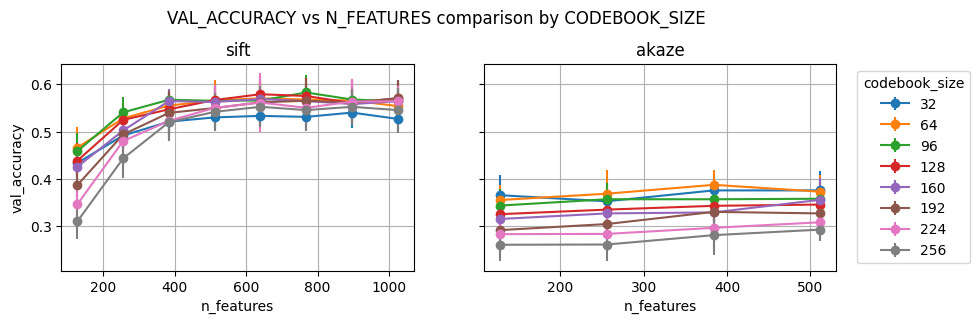

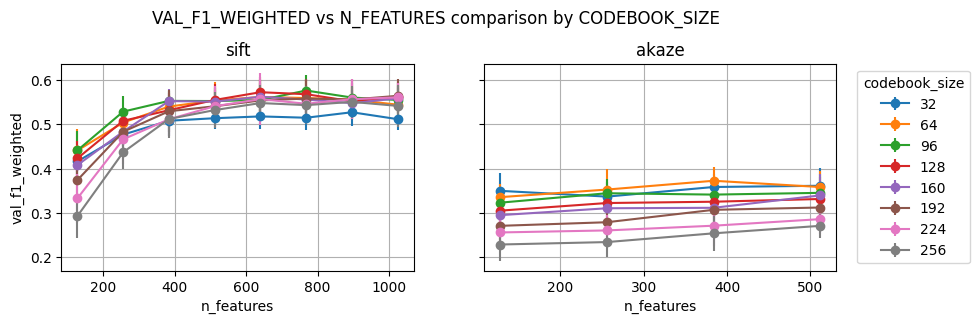

In [151]:
# ACCURACY
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='n_features',
    yvar='val_accuracy',
    zvar='codebook_size',
    figsize=(10, 3)
)
# F1-SCORE
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='n_features',
    yvar='val_f1_weighted',
    zvar='codebook_size',
    figsize=(10, 3)
)

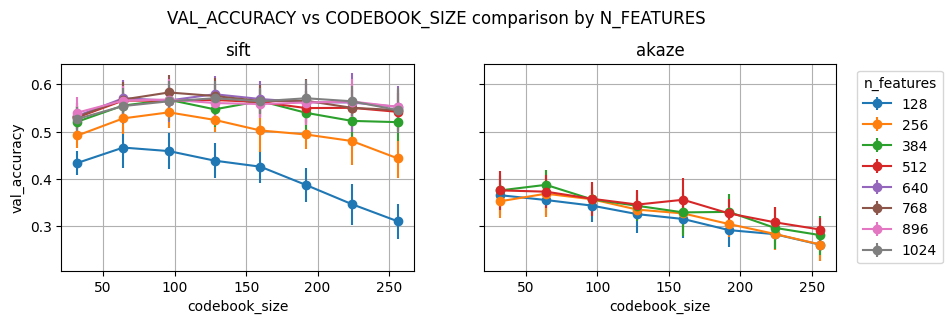

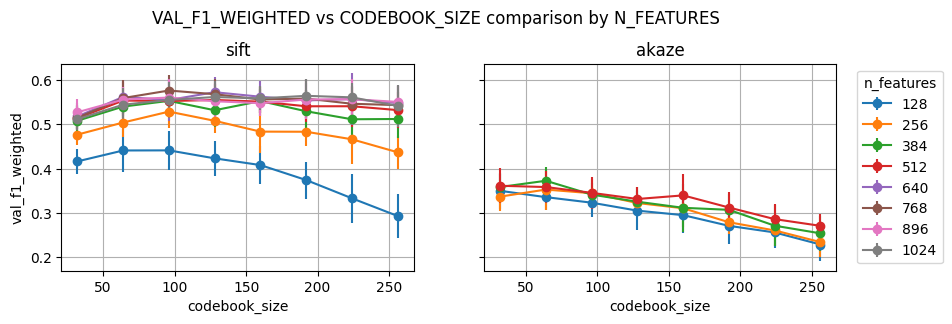

In [152]:
# ACCURACY
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='codebook_size',
    yvar='val_accuracy',
    zvar='n_features',
    figsize=(10, 3)
)
# F1-SCORE
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='codebook_size',
    yvar='val_f1_weighted',
    zvar='n_features',
    figsize=(10, 3)
)


AKAZE performed better at a lower codebook size but performed worse than SIFT overall. Therefore, we will focus on SIFT from now on.

Observing the plot, we see that SIFT performed better with a high number of features (800-1000).

The codebook size represents the number of words in the vocabulary that is used to represent the visual features of an image. The codebook is then created by clustering the visual features extracted from a set of training images using in our case either SIFT, AKAZE or DENSE_SIFT (next grid search). The size of the codebook, in our tests, had a significant impact in the BOVW model's performance. By increasing the codebook size, we got a better accuracy, but it also meant a longer computational time. We have tested it with values in range 32 to 256 by steps of 32 , and found the optimal values in most cases to be 96 to 224 in high dimensional spaces

From this visualization we can extract that intermidiate values for the codebook size and a high number of features should be used on the definitive DenseSIFT hyperparameter search.

<font color='green'>Test different values of k for the k-nn classifier. What performs best? </font> 

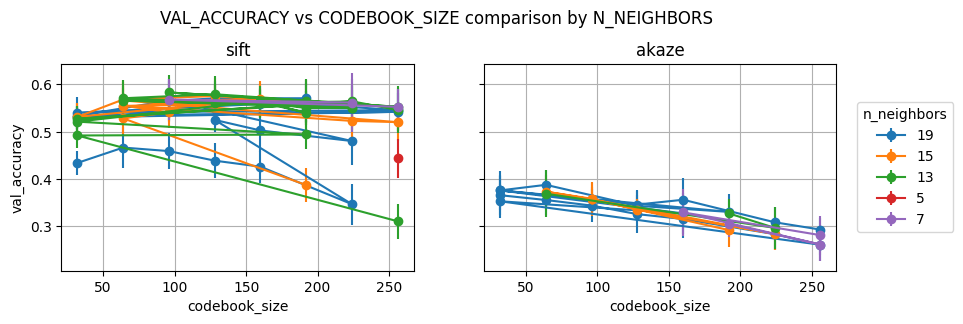

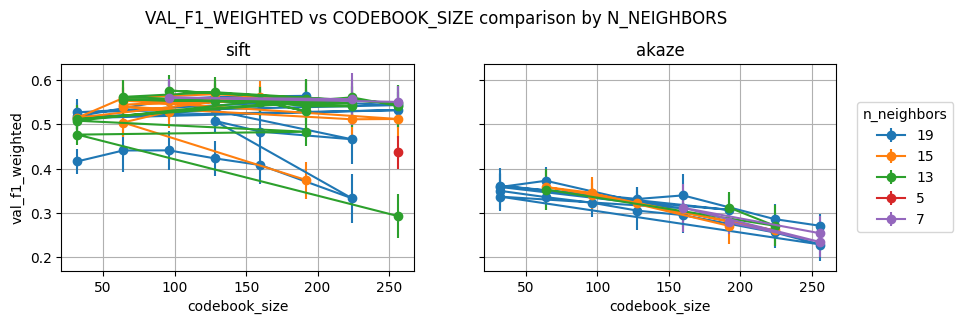

In [ ]:
# ACCURACY
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='codebook_size',
    yvar='val_accuracy',
    zvar='n_neighbors',
    figsize=(10, 3)
)
# F1-SCORE
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='codebook_size',
    yvar='val_f1_weighted',
    zvar='n_neighbors',
    figsize=(10, 3)
)

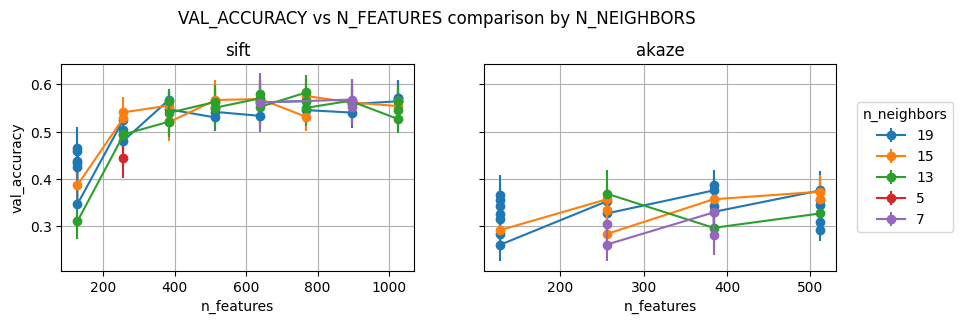

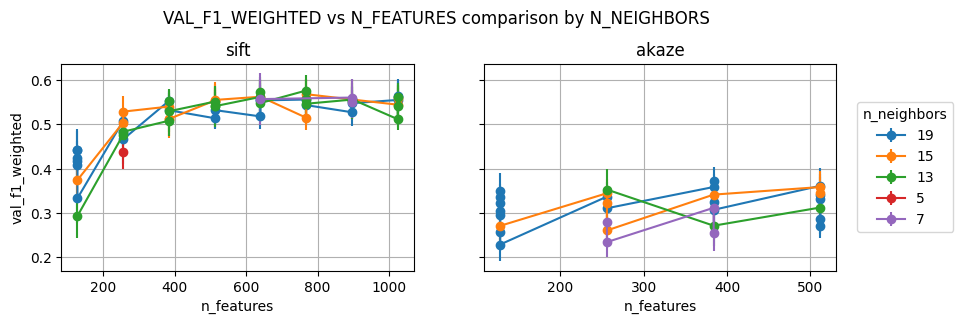

In [167]:
# ACCURACY
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='n_features',
    yvar='val_accuracy',
    zvar='n_neighbors',
    figsize=(10, 3)
)
# F1-SCORE
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='n_features',
    yvar='val_f1_weighted',
    zvar='n_neighbors',
    figsize=(10, 3)
)

Respect to the number of neighbors of the KNN predictor, we evidenciate that higher values are more interesting, since they assure a more representative poll compared to scenarios with few neighbors.

<font color='green'>Test other distances in k-nn classifier. Does that make a difference? Why? </font> 

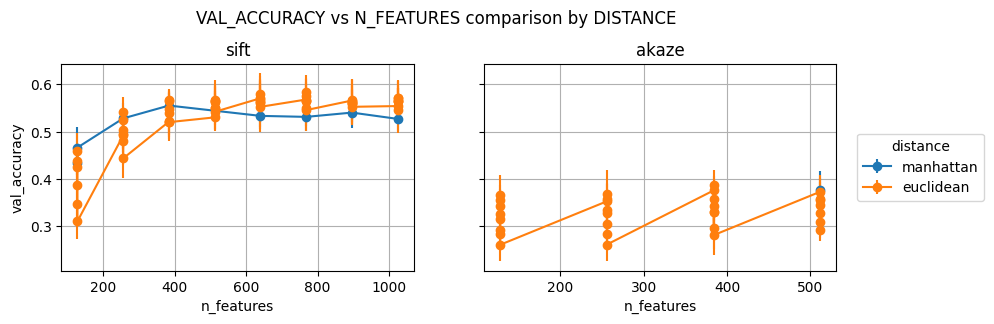

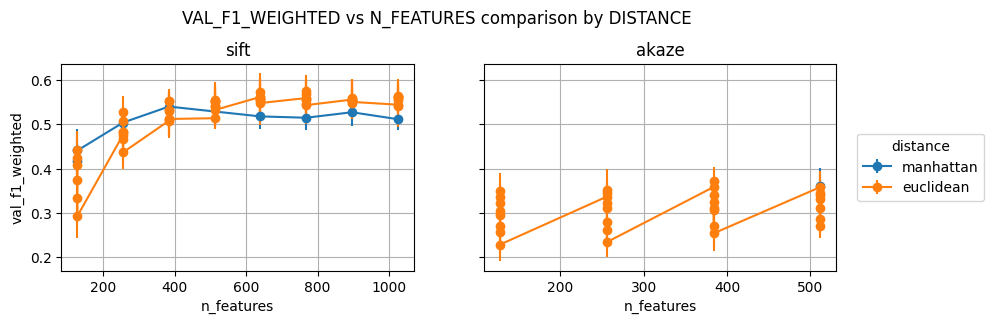

In [169]:
# ACCURACY
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='n_features',
    yvar='val_accuracy',
    zvar='distance',
    figsize=(10, 3)
)
# F1-SCORE
plot_params_comparison(
    df=df,
    detectors=['sift','akaze'],
    xvar='n_features',
    yvar='val_f1_weighted',
    zvar='distance',
    figsize=(10, 3)
)

About the distance metric employed in the KNN predictor we can say that both euclidean and manhattan have a similar performance. Manhattan distance is more sytable in lower dimensional spaces but at the 500 features mark, euclidean distance is consinstently better.

The reason behind is could be that Manhattan distance works better when the distances are unitary but at higher spaces this underperforms.

### Dense SIFT's  Grid Search

<font color='green'>Use dense SIFT instead of detected keypoints. Conclusions?</font> 

In [ ]:
start = time.time()

params = {
    'detector': ['dense_sift'],
    'n_features': np.arange(100, 1000, 100),
    'codebook_size': np.arange(64, 192, 32),
    'n_neighbors': [9, 13, 15, 21, 23],
    'metric': ["euclidean", "manhattan"],
    'step_size': [10, 20, 50, 70, 100],
    'dr_methods': ["pca", "lda"]
}




evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_knn_dense.csv'

results = []

### Dense SIFT case
for detector in params['detector']:
    if detector == 'dense_sift':
        for n_features in params['n_features']:
            for step_sizes in params['step_size']:

                train_descriptors, filtered_train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector=detector,
                    n_features=n_features,
                    step_size = step_sizes,
                    desc='Computing descriptors for TRAIN images...'
                )
                for codebook_size in params['codebook_size']:

                    cbook = generate_codebook(train_descriptors, codebook_size=codebook_size)
                    train_visual_words = compute_visual_words(
                        descriptors=train_descriptors,
                        codebook=cbook,
                        codebook_size=codebook_size,
                        desc="Computing visual words vocabulary with TRAIN descriptors..."
                    )

                    clf = KNeighborsClassifier(n_jobs=-1)
                    clf_grid = GridSearchCV(
                        estimator=clf,
                        param_grid={k: params[k] for k in ('n_neighbors', 'metric') if k in params},
                        cv=8,
                        scoring=evaluation_metrics,
                        refit="accuracy",
                        return_train_score=True)
                    clf_grid.fit(train_visual_words, filtered_train_labels)

                    idx_best_accuracy = np.argmin(clf_grid.cv_results_['rank_test_accuracy'])

                    # Params
                    n_neighbors = clf_grid.best_params_['n_neighbors']
                    distance = clf_grid.best_params_['metric']
                    results_data = [detector, n_features, step_sizes, codebook_size, n_neighbors, distance]

                    # Scores
                    for eval_metric in evaluation_metrics:
                        train_score = clf_grid.cv_results_['mean_train_' + eval_metric][idx_best_accuracy]
                        val_score = clf_grid.cv_results_['mean_test_' + eval_metric][idx_best_accuracy]
                        std_train_score = clf_grid.cv_results_['std_train_' + eval_metric][idx_best_accuracy]
                        std_val_score = clf_grid.cv_results_['std_test_' + eval_metric][idx_best_accuracy]
                        results_data.extend([train_score, val_score, std_train_score, std_val_score])

                    results.append(results_data)
                    print(f"Appended GridSearchCV results for {detector} with {n_features} features, {step_sizes} step size and {codebook_size} codebook size.")

columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance'] \

for eval_metric in evaluation_metrics:
    columns.extend([f'train_{eval_metric}', f'val_{eval_metric}', f'std_train_{eval_metric}', f'std_val_{eval_metric}'])

df = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")
end = time.time()
print(end - start)

In [253]:
df_dense = pd.read_csv('results/hyper_params_knn_dense.csv', index_col=0)
df_dense

detector  n_features  step_size  codebook_size  n_neighbors   distance  \
0    dense_sift         100         10             64           13  manhattan   
1    dense_sift         100         10             96           23  manhattan   
2    dense_sift         100         10            128           15  manhattan   
3    dense_sift         100         10            160           21  manhattan   
4    dense_sift         100         20             64           15  manhattan   
..          ...         ...        ...            ...          ...        ...   
175  dense_sift         900         70            160           13  euclidean   
176  dense_sift         900        100             64           15  euclidean   
177  dense_sift         900        100             96           15  euclidean   
178  dense_sift         900        100            128           15  euclidean   
179  dense_sift         900        100            160            9  manhattan   

     train_accuracy  val_accuracy  std_train_accuracy  std_val_accuracy  \
0          0.812106      0.764492            0.005227          0.036810   
1          0.799803      0.774617            0.007169          0.055335   
2          0.817499      0.774078            0.006463          0.038641   
3          0.824410      0.794280            0.005252          0.040849   
4          0.754082      0.716643            0.006652          0.038743   
..              ...           ...                 ...               ...   
175        0.717400      0.689538            0.006118          0.034069   
176        0.661503      0.616174            0.009156          0.027121   
177        0.682919      0.654420            0.007437          0.042784   
178        0.692869      0.663487            0.007253          0.040635   
179        0.720589      0.667734            0.007187          0.052457   

     train_f1_weighted  val_f1_weighted  std_train_f1_weighted  \
0             0.811640         0.762725               0.005284   
1             0.798809         0.772052               0.007271   
2             0.816539         0.770984               0.006497   
3             0.823228         0.790630               0.005504   
4             0.751927         0.712164               0.006722   
..                 ...              ...                    ...   
175           0.717487         0.687553               0.006091   
176           0.660769         0.612603               0.009151   
177           0.682421         0.653048               0.007549   
178           0.692414         0.661666               0.007371   
179           0.719838         0.664189               0.007152   

     std_val_f1_weighted  
0               0.038070  
1               0.057439  
2               0.039461  
3               0.042451  
4               0.040203  
..                   ...  
175             0.037170  
176             0.028908  
177             0.042031  
178             0.043334  
179             0.054092  

[180 rows x 14 columns]

In [254]:
df_results = pd.concat([df, df_dense], ignore_index=True)
df_results

detector  n_features step_size  codebook_size  n_neighbors   distance  \
0          sift         128         -             32           19  manhattan   
1          sift         128         -             64           19  manhattan   
2          sift         128         -             96           19  euclidean   
3          sift         128         -            128           19  euclidean   
4          sift         128         -            160           19  euclidean   
..          ...         ...       ...            ...          ...        ...   
271  dense_sift         900        70            160           13  euclidean   
272  dense_sift         900       100             64           15  euclidean   
273  dense_sift         900       100             96           15  euclidean   
274  dense_sift         900       100            128           15  euclidean   
275  dense_sift         900       100            160            9  manhattan   

     train_accuracy  val_accuracy  std_train_accuracy  std_val_accuracy  \
0          0.509000      0.433835            0.002884          0.025706   
1          0.536266      0.466259            0.008159          0.044187   
2          0.542721      0.458813            0.008276          0.038654   
3          0.517886      0.438598            0.009317          0.037132   
4          0.511202      0.425838            0.009693          0.034014   
..              ...           ...                 ...               ...   
271        0.717400      0.689538            0.006118          0.034069   
272        0.661503      0.616174            0.009156          0.027121   
273        0.682919      0.654420            0.007437          0.042784   
274        0.692869      0.663487            0.007253          0.040635   
275        0.720589      0.667734            0.007187          0.052457   

     train_f1_weighted  val_f1_weighted  std_train_f1_weighted  \
0             0.494981         0.416391               0.003404   
1             0.517455         0.440950               0.009801   
2             0.529797         0.441184               0.008971   
3             0.508955         0.423176               0.009857   
4             0.504340         0.408045               0.010266   
..                 ...              ...                    ...   
271           0.717487         0.687553               0.006091   
272           0.660769         0.612603               0.009151   
273           0.682421         0.653048               0.007549   
274           0.692414         0.661666               0.007371   
275           0.719838         0.664189               0.007152   

     std_val_f1_weighted  
0               0.028466  
1               0.049193  
2               0.043852  
3               0.039738  
4               0.042924  
..                   ...  
271             0.037170  
272             0.028908  
273             0.042031  
274             0.043334  
275             0.054092  

[276 rows x 14 columns]

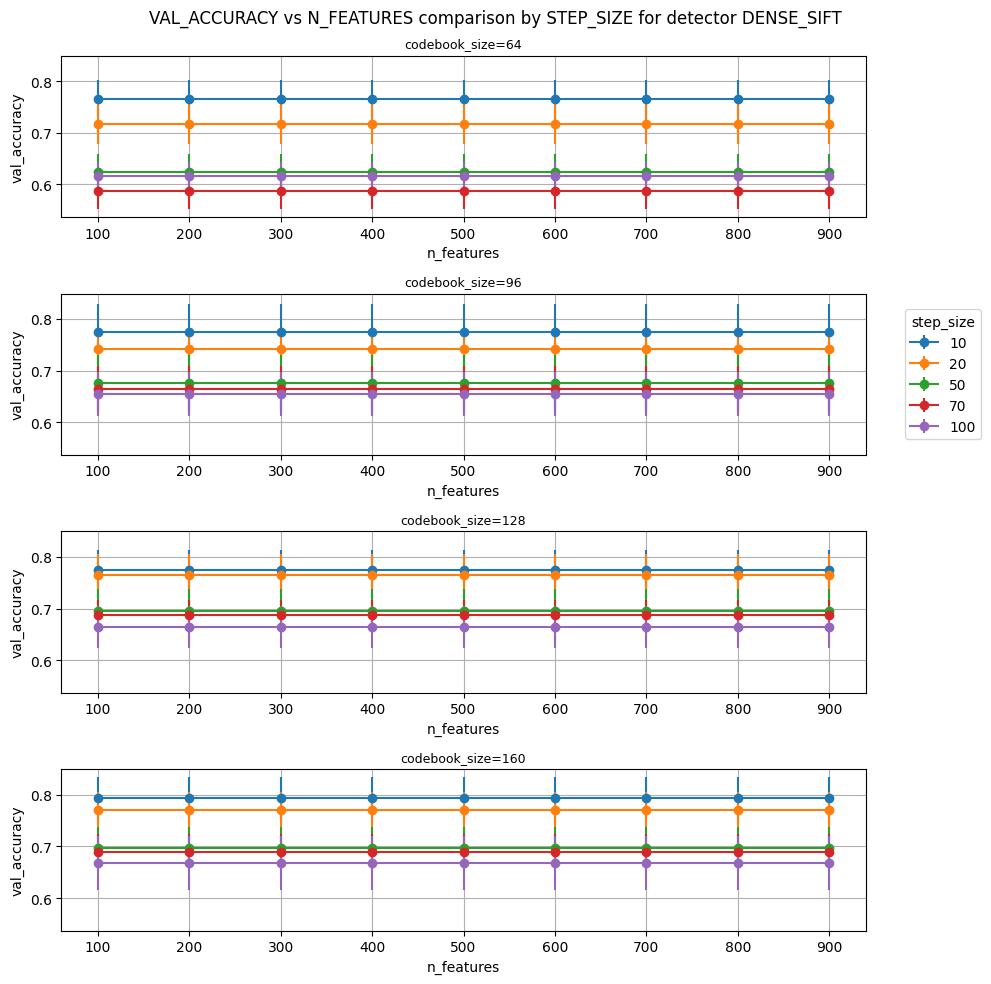

In [239]:
# ACCURACY
plot_params_detailed(
    df=df_dense,
    detector='dense_sift',
    breakdown='codebook_size',
    xvar='n_features',
    yvar='val_accuracy',
    zvar='step_size',
    figsize=(10, 10)
)
# F1-SCORE

### Dimensionality reduction with PCA and LDA

We find the cases obtained with GridSearch where the validation score was the highest.

<font color='green'>Play with reducing dimensionality. Conclusions? </font> 

#### Best params by Validation Accuracy

In [255]:
df_copy = df_results.copy()
df_copy = df_copy.sort_values("val_accuracy", ascending=False)
df_copy = df_copy.drop_duplicates(subset=["detector"], keep="first")
#df_copy.drop(columns=df.columns[0], axis=1, inplace=True)
df_copy = df_copy.drop(df_copy.iloc[:, 6:],axis = 1)
best_params = df_copy.values.tolist()

df_copy

detector  n_features step_size  codebook_size  n_neighbors   distance
219  dense_sift         700        10            160           21  manhattan
42         sift         768         -             96           13  euclidean
81        akaze         384         -             64           19  euclidean

### Apply dimensionality reduction and compare the results

In [ ]:
results = []
evaluation_metrics = ['accuracy', 'f1_weighted']
results_folder = 'results'
filename = 'hyper_params_dim_red.csv'
methods = ['pca', 'lda']

for params in best_params:
    train_descriptors, train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector=params[0],
                    n_features=params[1],
                    #step_size = 
                    desc='Computing descriptors for TRAIN images...'
                )
    test_descriptors, test_labels = compute_descriptors(
                    images=test_images,
                    labels=test_labels,
                    detector=params[0],
                    n_features=params[1],
                    #step_size = 
                    desc='Computing descriptors for TEST images...',
                    testing = True
                )
    cbook = generate_codebook(train_descriptors, params[3])
    train_visual_words = compute_visual_words(
        descriptors=train_descriptors,
        codebook=cbook,
        codebook_size=params[3],
        desc="Computing visual words vocabulary with TRAIN descriptors...",
        verbose=True)

    test_visual_words = compute_visual_words(
        descriptors=test_descriptors,
        codebook=cbook,
        codebook_size=params[3],
        desc="Computing visual words vocabulary with Test descriptors...",
        verbose=True)
    clf = KNeighborsClassifier(n_neighbors = params[4],metric = params[5] ,n_jobs=-1)
    clf.fit(train_visual_words, train_labels)
    print('\nRegular')
    reg_res = evaluate_vw_predictions(test_visual_words,test_labels, clf)

    for method in methods:
        if method == 'pca':
            reduced_dims = np.arange(5, 161, 20)
        elif method == 'lda':
            reduced_dims = np.arange(4, len(np.unique(test_labels))) 
        for red_dim in reduced_dims:
            red_clf = KNeighborsClassifier(n_neighbors = params[4],metric = params[5] ,n_jobs=-1)
            dim_red = get_dimension_reduction(dim_red_name=method, n_components=red_dim)
            red_visual_words = dim_red.fit_transform(train_visual_words, train_labels)
            if method == 'pca':
                plt.plot(np.cumsum(dim_red.explained_variance_ratio_), 'ro-')
                plt.grid()
                plt.title("PCA with " + str(red_dim) + " components")
                plt.savefig(str(red_dim) + ".png" )
                plt.close()
            red_clf.fit(red_visual_words, train_labels)
            red_visual_words_test = dim_red.transform(test_visual_words)
            print('\nDim red')
            res = evaluate_vw_predictions(red_visual_words_test,test_labels, red_clf)

            results_data = [params[0], params[1], params[2], params[3], params[4], params[5], method, red_dim, reg_res ,res]

            results.append(results_data)
            print(f" Using {params[0]} with {params[1]} features, {params[2]} step size and {params[3]} codebook size. Appended GridSearch results for {method} with {red_dim} reduced dimension.")

            
columns = ['detector', 'n_features','step_size', 'codebook_size', 'n_neighbors', 'distance', 'method', 'reduced_dimensions', 'regular_accuracy', 'dim_red_accuracy']
df_dr = pd.DataFrame(results, columns=columns)
os.makedirs(results_folder, exist_ok=True)
df_dr.to_csv(os.path.join(results_folder, filename))
print(f"Saved results to {os.path.join(results_folder, filename)}")

In [270]:
df_dim_red = pd.read_csv('results/hyper_params_dim_red.csv', index_col=0)
df_dim_red

detector  n_features  step_size  codebook_size  n_neighbors   distance  \
0   dense_sift         600         10            160           21  manhattan   
1   dense_sift         600         10            160           21  manhattan   
2   dense_sift         600         10            160           21  manhattan   
3   dense_sift         600         10            160           21  manhattan   
4   dense_sift         600         10            160           21  manhattan   
5   dense_sift         600         10            160           21  manhattan   
6   dense_sift         600         10            160           21  manhattan   
7   dense_sift         600         10            160           21  manhattan   
8   dense_sift         600         10            160           21  manhattan   
9   dense_sift         600         10            160           21  manhattan   
10  dense_sift         600         10            160           21  manhattan   
11  dense_sift         600         10            160           21  manhattan   

   method  reduced_dimensions  regular_accuracy  dim_red_accuracy  
0     pca                   5          0.784387          0.671623  
1     pca                  25          0.784387          0.755886  
2     pca                  45          0.784387          0.754647  
3     pca                  65          0.784387          0.737299  
4     pca                  85          0.784387          0.734820  
5     pca                 105          0.784387          0.728625  
6     pca                 125          0.784387          0.727385  
7     pca                 145          0.784387          0.733581  
8     lda                   4          0.784387          0.790582  
9     lda                   5          0.784387          0.793061  
10    lda                   6          0.784387          0.801735  
11    lda                   7          0.784387          0.819083

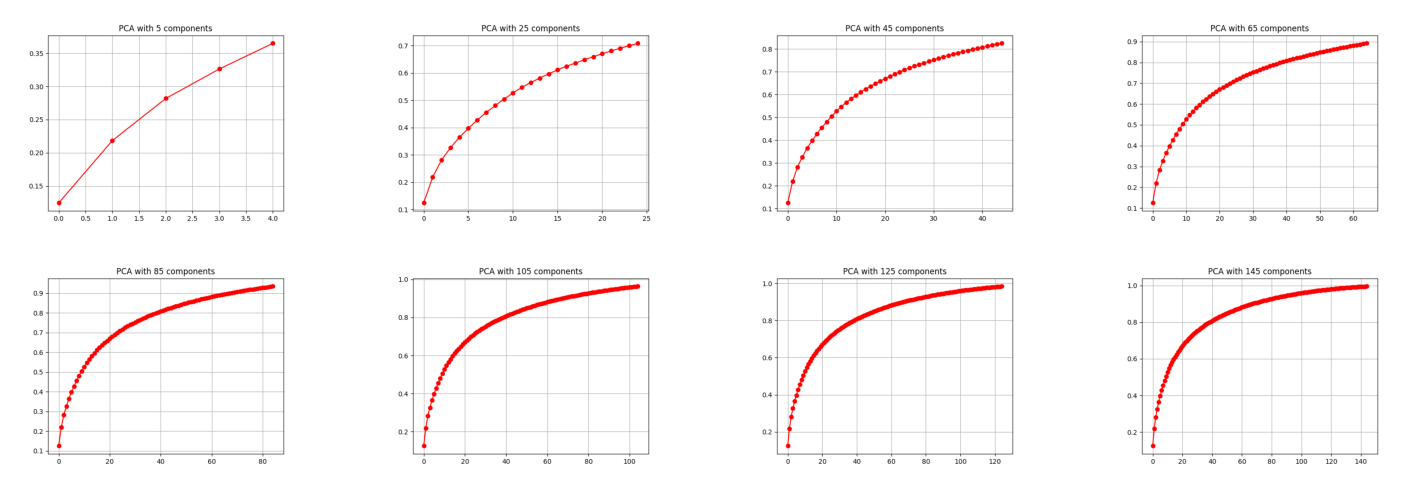

In [283]:
# Fit PCA to the training data
pca_an = PCA()
X_pca = pca_an.fit_transform(train_visual_words, train_labels)

# PLOTTING THE CUMULATIVE SUM OF THE EXPLAINED VARIANCE RATIO
fig = plt.figure(figsize=(15, 5))
columns = 4
rows = 2
counter_im = 5 #based on the naming of the images, this may need to be changed

for i in range(1, columns*rows +1):
    try:
        img = mpimg.imread(str(counter_im)+'.png') # getting the images with names 5.png, 25.png, 45.png...
        fig.add_subplot(rows, columns, i)
        plt.grid(False)
        plt.axis('off')
        plt.tight_layout()
        plt.imshow(img)
        counter_im = counter_im + 20
    except:
        pass

plt.show()

The plots show the data variation based on the number of components. As we can see in those cases, there aren't many independent or redundant features. The variation of data highly depends on the first components, but it still steadly increases to the end.

## K-Fold Crossvalidation Pipeline 

The results were mainly based on the cross validation inside the GridSearch, which helped us tune the hyperparameters and optimised the model performance by evaluating the model on multiple splits of the data.

### Read and Process Data

In [61]:
train_images_filenames = pickle.load(open('MIT_split/train_images_filenames.dat',"rb"))
test_images_filenames = pickle.load(open('MIT_split/test_images_filenames.dat',"rb"))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('MIT_split/train_labels.dat',"rb")) 
test_labels = pickle.load(open('MIT_split/test_labels.dat',"rb"))

In [62]:
train_images_filenames = preprocess_paths(train_images_filenames)
test_images_filenames = preprocess_paths(test_images_filenames)

In [63]:
train_images = load_images(files=train_images_filenames, desc='Loading TRAIN images...')
test_images = load_images(files=test_images_filenames, desc='Loading TEST images...')

images = np.array(train_images + test_images)
labels = np.array(train_labels + test_labels)

Loading TRAIN images...: 100%|██████████| 1881/1881 [00:00<00:00, 2004.36it/s]


read: 1881 images


Loading TEST images...: 100%|██████████| 807/807 [00:00<00:00, 2191.60it/s]


read: 807 images


### Cross-validation loop

In [66]:
splits = 10
kfold = KFold(n_splits=splits, shuffle=True, random_state=0)
# Iterate over the K-folds
results = []
for train_index, test_index in kfold.split(labels):
    # Split the data into training and test sets
    Y_train, Y_test = labels[train_index], labels[test_index]
    X_train, X_test = images[train_index], images[test_index]

    train_descriptors, train_labels = compute_descriptors(
                    images=train_images,
                    labels=train_labels,
                    detector='dense_sift',
                    n_features=TODO,
                    step_size =TODO,
                    desc='Computing descriptors for TRAIN images...'
                )
    test_descriptors, test_labels = compute_descriptors(
                    images=test_images,
                    labels=test_labels,
                    detector='dense_sift',
                    n_features=300,
                    step_size = 50,
                    desc='Computing descriptors for TEST images...',
                    testing = True
                )
    cbook = generate_codebook(train_descriptors, 128)
    train_visual_words = compute_visual_words(
        descriptors=train_descriptors,
        codebook=cbook,
        codebook_size=128,
        desc="Computing visual words vocabulary with TRAIN descriptors...",
        verbose=True)

    test_visual_words = compute_visual_words(
        descriptors=test_descriptors,
        codebook=cbook,
        codebook_size=128,
        desc="Computing visual words vocabulary with Test descriptors...",
        verbose=True)
    clf = KNeighborsClassifier(n_neighbors = 15,metric = 'manhattan' ,n_jobs=-1)
    clf.fit(train_visual_words, train_labels)
    print('\nRegular')
    reg_res = evaluate_vw_predictions(test_visual_words,test_labels, clf)
    results.append(reg_res)

print(f'Average: {np.average(results)}')

Computing visual words vocabulary with TRAIN descriptors...: 100%|██████████| 1881/1881 [00:00<00:00, 4301.77it/s]



Generated 1881 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0


Computing visual words vocabulary with Test descriptors...: 100%|██████████| 807/807 [00:00<00:00, 4184.77it/s]



Generated 807 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0

Regular

The trained model generates results with 66.54275092936803 accuracy.


Computing visual words vocabulary with TRAIN descriptors...: 100%|██████████| 1881/1881 [00:00<00:00, 4241.67it/s]



Generated 1881 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0


Computing visual words vocabulary with Test descriptors...: 100%|██████████| 807/807 [00:00<00:00, 4052.15it/s]



Generated 807 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0

Regular

The trained model generates results with 66.54275092936803 accuracy.


Computing visual words vocabulary with TRAIN descriptors...: 100%|██████████| 1881/1881 [00:00<00:00, 5799.69it/s]



Generated 1881 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0


Computing visual words vocabulary with Test descriptors...: 100%|██████████| 807/807 [00:00<00:00, 5546.54it/s]



Generated 807 histograms with a k=128 vocabulary.

Number of images where keypoints were not detected: 0

Regular

The trained model generates results with 66.54275092936803 accuracy.


Computing descriptors for TRAIN images...:  20%|██        | 384/1881 [00:07<00:32, 45.74it/s]

KeyboardInterrupt: 

## Answers and Conclusions

<font color='green'>Test different amounts of local features. What performs best?</font>  
<font color='green'>Use dense SIFT instead of detected keypoints. Conclusions?</font> 

We tried several descriptors including BRISK, KAZE, AKAZE, SIFT and DenseSIFT. Not all of them allowed a wide selection range of features so we we decided to perform a crossvalidated grid search over the last three-
The search and generated plots showcased that DenseSIFT's local features produces better performance. 

<font color='green'>Test different amounts of codebook sizes k. What performs best? </font> 

The codebook size represents the number of words in the vocabulary that is used to represent the visual features of an image. The codebook is then created by clustering the visual features extracted from a set of training images using in our case either SIFT, AKAZE or DENSE_SIFT. The size of the codebook, in our tests, had a major impact in the BOVW model's performance. By increasing the codebook size, we got a better accuracy, but it also meant a longer computational time. We have tested it with values in range …. , and found the optimal values in most cases to be … 


<font color='green'>Test different values of k for the k-nn classifier. What performs best? </font> 

In this case there is again a trade-off between accuracy and computational efficiency that is desired. A larger value helped in increasing the accuracy, as the model considered more information from the nearest neighbours, but it increased the computational cost. Best results were with…


<font color='green'>Test other distances in k-nn classifier. Does that make a difference? Why? </font> 

<font color='green'>Play with reducing dimensionality. Conclusions? </font> 


<font color='green'>Cross-validate everything (topic covered on Wednesday)</font> 

We have added a cross validation part in our project, but the results were mainly based on the cross validation part included in the GridSearch. It helped us tune the hyperparameters and optimised the model performance by evaluating the model on multiple splits of the data.